In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import tensorflow_probability as tfp

from src.ksd.ksd import KSD, PKSD, MPKSD, SPKSD
from src.ksd.kernel import IMQ
import src.ksd.langevin as mcmc


In [2]:
tf.random.set_seed(2022)

# Set-ups: Bi-modal mixture of Gaussian
We consider the first example in the experiments section of the paper. The target density is
$$
    p(x) \propto \pi_p \exp\left( - 0.5 * \| x \|_2^2 \right) + (1 - \pi_p) \exp\left( -0.5 * \| x - e_1\|_2^2 \right),
$$
where $\pi_p = 0.5$, and $e_1 = (1, 0, \ldots, 0)^\intercal \in \mathbb{R}^d$.

In [3]:
dim = 2
pi_p = 0.5

In [4]:
mean1 = tf.zeros(dim)
mean2 = tf.eye(dim)[0, :] * 6.

def log_prob(x):
    """Log prob density of the target up to an additive constant"""
    log_ratio1 = tf.math.log(pi_p)
    log_ratio2 = tf.math.log(1-pi_p)
    
    exp1 = tf.reduce_sum((x - mean1)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x - mean2)**2, axis=-1) # n
    exps = tf.stack([-0.5 * exp1 + log_ratio1, -0.5 * exp2 + log_ratio2]) # 2 x n
    return tf.math.reduce_logsumexp(exps, axis=0) # n

2022-11-09 11:41:56.464954: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-09 11:41:56.465009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-11-09 11:41:56.465018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-11-09 11:41:56.465138: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-11-09 11:41:56.465172: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-11-09 11:41:56.465179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-11-09 11:41:56.466112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

Samples are drawn from the *left component*, i.e. the same density but with $\pi_p$ replaced by $\pi_q = 1$.

In [5]:
def sample_from_target(n, ratio):
    """Sample from the candidate distribution"""
    mix1 = tf.random.normal((n, dim)) + mean1
    mix2 = tf.random.normal((n, dim)) + mean2
    unif = tf.random.uniform((n, 1))
    x = tf.where(unif <= ratio, mix1, mix2)
    return x

In [6]:
# draw sample
n = 1000
samples = sample_from_target(n, ratio=1.)

# KSD test
The goal is to test $H_0: Q = P$ against $H_1: Q \neq P$.

To perform KSD test, we need to instantiate
1. a positive definite kernel: we use IMQ kernels with the median heuristic (see paper for details)
2. a KSD object, which takes in a p.d. kernel and the log prob of the target

In [7]:
kernel = IMQ(med_heuristic=True)
ksd = KSD(kernel=kernel, log_prob=log_prob)

In [8]:
# compute test statistic and p-value using 1000 bootstrap samples 
ksd_hat, ksd_pval = ksd.test(x=samples, num_boot=1000)

print("KSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(ksd_hat, ksd_pval))

2022-11-09 11:41:58.293566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


KSD test: 
test statistic: -0.00159, p-value: 0.901


The large $p$-value suggests no evidence of rejection, even though the sample has completely missed the other mode. 

This is because the score functions of the target distribution $P$ and the candidate distribution $Q$ are very similar on regions where we have sample.

(Even though the population KSD is always non-negative, the test statistic can be negative because a U-statistic does not ensure positivity.)

# pKSD test
To perform pKSD test, we need to provide a few more things (see paper for details):
1. a perturbation kernel: in this case a MH transition kernel leaving $p$ invariant,
2. number of steps to apply the perturbation kernel.
3. a list of candidate jump scales for the transition kernel,
4. a training set for finding the optimal jump scale, and a test set for computing the p-value
5. starting points for the optimiser

In [9]:
tf.random.set_seed(2022)

In [10]:
# MH transition kernel
mh_kernel = mcmc.RandomWalkMH

# number of steps to apply transition kernel
T = 10

# candidate jump scales
jump_ls = tf.linspace(0.5, 1.5, 21)
# jump_ls = tf.constant([1.0])

# train/test split
ntrain = n//2
sample_train, sample_test = samples[:ntrain, ], samples[ntrain:, ]

# starting points to initialise optimiser for finding
# modes and Hessians
init_points = tf.concat([
    sample_train[:(ntrain//2)], 
    tf.random.uniform((ntrain//2, dim), minval=-10, maxval=10) 
], axis=0) # ntrain x dim

In [11]:
# instantiate PKSD class
pksd = MPKSD(kernel=kernel, pert_kernel=mh_kernel, log_prob=log_prob)

In [14]:
# find modes and Hessians
pksd.find_modes(init_points, threshold=1., max_iteration=500)

In [15]:
# compute test statistic and p-value using 1000 bootstrap samples 
pksd_hat, pksd_pval = pksd.test(
    xtrain=sample_train, 
    xtest=sample_test, 
    T=T, 
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("pKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(pksd_hat, pksd_pval))

pKSD test: 
test statistic: 0.136, p-value: 0.001


In [16]:
# compute test statistic and p-value using 1000 bootstrap samples 
pksd_hat, pksd_pval = pksd.test(
    xtrain=sample_train, 
    xtest=sample_test, 
    T=T, 
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("pKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(pksd_hat, pksd_pval))

pKSD test: 
test statistic: 0.114, p-value: 0.001


Unlike KSD, the small $p$-value of the pKSD test suggests a clear rejection at a level $\alpha = 0.05$, demonstrating the capability of pKSD in detecting differences in mixing proportions.

A similar observation could be drawn if the sample was drawn from *both* components but with a different mixing proportion, i.e., setting $\pi_q \in (0, 1)$ with $\pi_q \neq \pi_p$.

# new pKSD test

In [17]:
# MH transition kernel
mh_kernel = mcmc.RandomWalkMH

# number of steps to apply transition kernel
T = 10

# candidate jump scales
# jump_ls = tf.linspace(0.5, 1.5, 21)
jump_ls = tf.constant([1.0])

# train/test split
ntrain = n//2
sample_train, sample_test = samples[:ntrain, ], samples[ntrain:, ]

# starting points to initialise optimiser for finding
# modes and Hessians
init_points = tf.concat([
    sample_train[:(ntrain//2)], 
    tf.random.uniform((ntrain//2, dim), minval=-10, maxval=10) 
], axis=0) # ntrain x dim

In [21]:
# instantiate PKSD class
pksd = MPKSD(kernel=kernel, pert_kernel=mh_kernel, log_prob=log_prob)

In [22]:
# find modes and Hessians
pksd.find_modes(init_points, threshold=1., max_iteration=500)

In [23]:
= N(0, 1) and # compute test statistic and p-value using 1000 bootstrap samples 
pksd_hat, pksd_pval = pksd.test(
    xtrain=sample_train, 
    xtest=sample_test, 
    T=T, 
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("pKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(pksd_hat, pksd_pval))

pKSD test: 
test statistic: -0.00539, p-value: 0.884


# New test with multiple summands

In [19]:
tf.random.set_seed(2022)

In [20]:
# MH transition kernel
mh_kernel = mcmc.RandomWalkMH

# number of steps to apply transition kernel
T = 10

# candidate jump scales
jump_ls = tf.linspace(0.5, 1.5, 21)
# jump_ls = tf.constant([1.0])

# train/test split
ntrain = n//2
sample_train, sample_test = samples[:ntrain, ], samples[ntrain:, ]

# starting points to initialise optimiser for finding
# modes and Hessians
init_points = tf.concat([
    sample_train[:(ntrain//2)], 
    tf.random.uniform((ntrain//2, dim), minval=-10, maxval=10) 
], axis=0) # ntrain x dim

In [21]:
# instantiate PKSD class
pksd = SPKSD(kernel=kernel, pert_kernel=mh_kernel, log_prob=log_prob)

In [22]:
# find modes and Hessians
pksd.find_modes(init_points, threshold=1., max_iteration=500)

In [23]:
# compute test statistic and p-value using 1000 bootstrap samples 
pksd_hat, pksd_pval = pksd.test(
    x=samples, 
    T=T,
    jump_ls=jump_ls, 
    num_boot=1000, 
  )

print("pKSD test: \ntest statistic: {:.3g}, p-value: {:.3g}".format(pksd_hat, pksd_pval))

pKSD test: 
test statistic: 1.24, p-value: 0.001


<AxesSubplot:xlabel='theta', ylabel='pksd_val'>

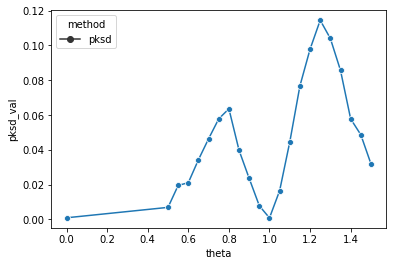

In [55]:
# plot contributions of each pKSD in spKSD

import pandas as pd
import seaborn as sns

spksd_val = tf.reduce_sum(pksd.pksd_vals)
contrib_df = pd.DataFrame({
    "pksd_val": [(tf.reduce_sum(x) / spksd_val).numpy() for x in pksd.pksd_vals],
    "theta": [0] + jump_ls.numpy().tolist(),
    "method": "pksd"
})
sns.lineplot(data=contrib_df, x="theta", y="pksd_val", markers=True, style="method")

# Visualise samples before and after perturbations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

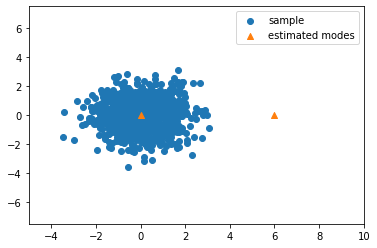

In [51]:
# visualise samples and estimated mode locations
modes_list = pksd.proposal_dict["modes"]
modes = tf.concat(modes_list, axis=0)

_ = plt.scatter(samples[:, 0], samples[:, 1], label="sample")
_ = plt.scatter(modes[:, 0], modes[:, 1], marker="^", label="estimated modes")
_ = plt.legend()
_ = plt.xlim(-5., 10.)
_ = plt.ylim(-7.5, 7.5)

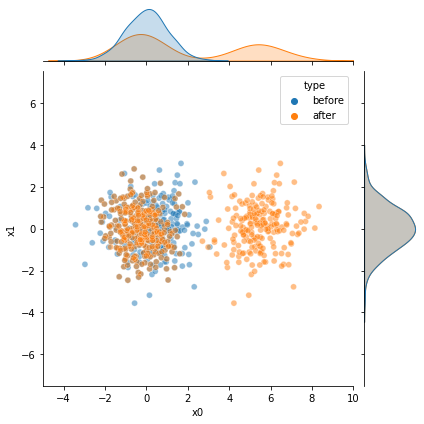

In [52]:
# plot test data before and after perturbation
samples_df = pd.DataFrame({
    "x0": tf.concat([pksd.x[0, :, 0], pksd.x[-1, :, 0]], axis=0),
    "x1": tf.concat([pksd.x[0, :, 1], pksd.x[-1, :, 1]], axis=0),
    "type": ["before"]*(n-ntrain) + ["after"]*(n-ntrain)
})

_ = sns.jointplot(
    data=samples_df,
    x="x0",
    y="x1",
    hue="type",
    xlim=[-5., 10.],
    ylim=[-7.5, 7.5],
    alpha=0.5
)